<a href="https://colab.research.google.com/github/pag6521/alist-doc/blob/main/examples/vision/ipynb/patch_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmenting convnets with aggregated attention

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2022/01/22<br>
**Last modified:** 2022/01/22<br>
**Description:** Building a patch-convnet architecture and visualizing its attention maps.

## Introduction

Vision transformers ([Dosovitskiy et. al](https://arxiv.org/abs/2010.11929))
have emerged as a powerful alternative to Convolutional Neural Networks.
ViTs process the images in a patch-based manner. The image information
is then aggregated into a `CLASS` token. This token correlates to the
most important patches of the image for a particular classification decision.

The interaction between the `CLASS` token and the patches can be visualized
to help explain a classification decision. In the academic paper
[Augmenting convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692)
by Touvron et. al, the authors propose to set up an equivalent visualization for
convnets. They propose to substitute the global average pooling layer
of a convnet with a Transformer layer. The self-attention layer of the
Transformer would produce attention maps that correspond to the
most attended patches of the image for the classification decision.

In this example, we minimally implement the ideas of
[Augmenting Convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692).
The main goal of this example is to cover the following ideas, with
minor modifications (to adjust the implementation with CIFAR10):

- The simple design for the attention-based pooling layer, such that
    it explicitly provides the weights (importance) of the different
    patches.
- The novel architecture of convnet is called the **PatchConvNet** which
    deviates from the age old pyramidal architecture.

## Setup and Imports

This example requires TensorFlow Addons, which can be installed using
the following command:

```shell
pip install -U tensorflow-addons
```

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import ops
from tensorflow import data as tf_data

# Set seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

## Hyperparameters

In [2]:
# DATA
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf_data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10  # for CIFAR 10

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.

# ARCHITECTURE
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

## Load the CIFAR10 dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf_data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf_data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


NameError: name 'BUFFER_SIZE' is not defined

## Augmentation layers

In [3]:

def get_preprocessing():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="preprocessing",
    )
    return model


def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


## Convolutional stem

The stem of the model is a lightweight preprocessing module that
maps images pixels to a set of vectors (patches).

In [4]:

def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": ops.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem


## Convolutional trunk

The trunk of the model is the most compute-intesive part. It consists
of `N` stacked residual convolutional blocks.

In [5]:

class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio,
            activation="relu",
            use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x


class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692

    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio

    Inputs:
        Convolutional features extracted from the conv stem.

    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "ratio": self.ratio,
                "dimensions": self.dimensions,
                "depth": self.depth,
            }
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": ops.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        return x


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Attention Pooling

The output of the convolutional trunk is attended with a trainable
_query_ class token. The resulting attention map is the weight of
every patch of the image for a classification decision.

In [7]:

class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the
    trunk with the CLS token.

    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.

    Inputs:
        Flattened patches from the trunk.

    Outputs:
        The modifies CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = keras.Variable(ops.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1,
            key_dim=self.dimensions,
            dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=ops.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=ops.gelu),
            ]
        )
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()

    def call(self, x):
        batch_size = ops.shape(x)[0]
        # Expand the class token batch number of times.
        class_token = ops.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = ops.concatenate([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        # Build the logits
        logits = self.dense(class_token)
        return logits, ops.squeeze(viz_weights)[..., 1:]


## Patch convnet

The patch-convnet is shown in the figure below.

| ![image model](https://i.imgur.com/NHiQeac.png) |
| :--: |
| [Source](https://arxiv.org/abs/2112.13692) |

All the modules in the architecture are built in the earlier seciton.
In this section, we stack all of the different modules together.

In [8]:

class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        preprocessing_model,
        train_augmentation_model,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                "train_augmentation_model": self.train_augmentation_model,
                "preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for grad, var in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        augmented_images = self.preprocessing_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights


## Callbacks

This callback will plot the image and the attention map overlayed on
the image.

In [9]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_labels = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            test_augmented_images = self.model.preprocessing_model(test_images)
            # Pass through the stem.
            test_x = self.model.stem(test_augmented_images)
            # Pass through the trunk.
            test_x = self.model.trunk(test_x)
            # Pass through the attention pooling block.
            _, test_viz_weights = self.model.attention_pooling(test_x)
            # Reshape the vizualization weights
            num_patches = ops.shape(test_viz_weights)[-1]
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            # Take a random image and its attention weights.
            index = np.random.randint(low=0, high=ops.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            # Plot the images and the overlayed attention map.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(
                selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent()
            )
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()


## Learning rate schedule

In [10]:

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = np.pi

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = ops.cos(
            self.pi
            * (ops.cast(step, "float32") - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * ops.cast(step, "float32") + self.warmup_learning_rate
            learning_rate = ops.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return ops.where(
            step > self.total_steps,
            0.0,
            learning_rate,
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

## Training

We build the model, compile it, and train it.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:671: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 124ms/step - accuracy: 0.1831 - top-5-accuracy: 0.6632 - loss: 0.1262 - val_loss: 0.1175
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.3885 - top-5-accuracy: 0.8933 - loss: 0.0710 - val_loss: 0.0699
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.4810 - top-5-accuracy: 0.9298 - loss: 0.0220 - val_loss: 0.0322
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.5552 - top-5-accuracy: 0.9487 - loss: 0.0022 - val_loss: 0.0477
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6076 - top-5-accuracy: 0.9613 - loss: -0.0089

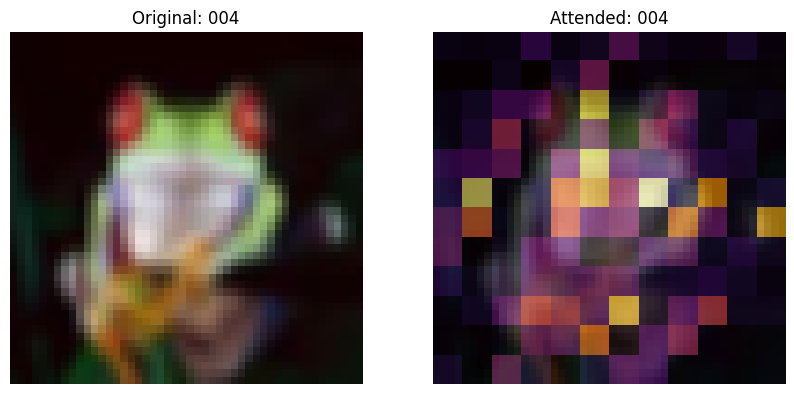

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.6076 - top-5-accuracy: 0.9613 - loss: -0.0090 - val_loss: -0.0307
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.6401 - top-5-accuracy: 0.9689 - loss: -0.0492 - val_loss: -0.0890
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.6768 - top-5-accuracy: 0.9741 - loss: -0.0627 - val_loss: -0.0556
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.7073 - top-5-accuracy: 0.9808 - loss: -0.0726 - val_loss: -0.0604
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.7410 - top-5-accuracy: 0.9830 - loss: -0.0921 - val_loss: -0.1732
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7644 - top-5-accuracy: 0.9856 - loss: -0.1222

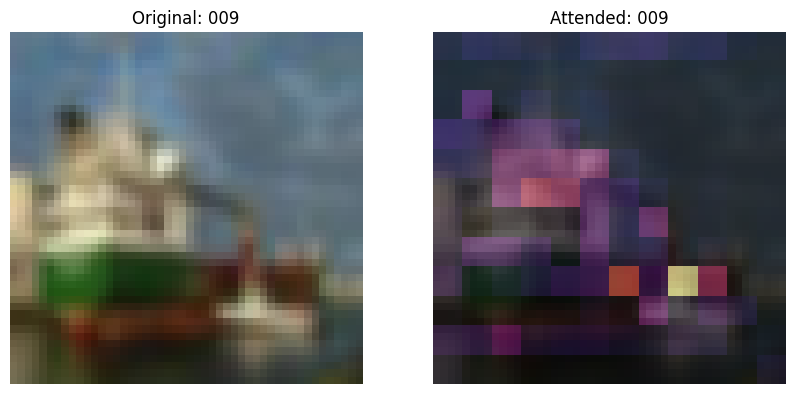

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.7644 - top-5-accuracy: 0.9856 - loss: -0.1222 - val_loss: -0.0930
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.7845 - top-5-accuracy: 0.9878 - loss: -0.1172 - val_loss: -0.1897
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.7982 - top-5-accuracy: 0.9878 - loss: -0.1424 - val_loss: -0.1465
Epoch 13/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - accuracy: 0.8150 - top-5-accuracy: 0.9912 - loss: -0.1538 - val_loss: -0.2195
Epoch 14/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.8221 - top-5-accuracy: 0.9921 - loss: -0.1491 - val_loss: -0.1485
Epoch 15/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8302 - top-5-accuracy: 0.9928 - loss: -0.1530

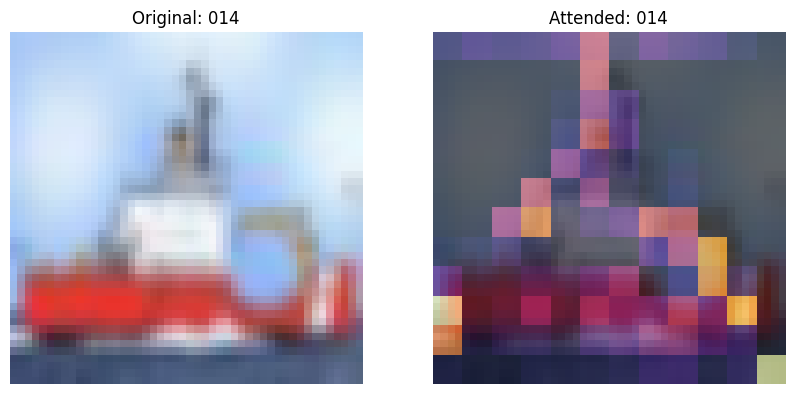

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8301 - top-5-accuracy: 0.9928 - loss: -0.1530 - val_loss: 9.6746e-04
Epoch 16/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8439 - top-5-accuracy: 0.9938 - loss: -0.1330 - val_loss: -0.2131
Epoch 17/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.8487 - top-5-accuracy: 0.9933 - loss: -0.1726 - val_loss: -0.1528
Epoch 18/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.8541 - top-5-accuracy: 0.9948 - loss: -0.1733 - val_loss: -0.1481
Epoch 19/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.8693 - top-5-accuracy: 0.9960 - loss: -0.1918 - val_loss: -0.1903
Epoch 20/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8683 - top-5-accuracy: 0.9963 - loss: -0.2072

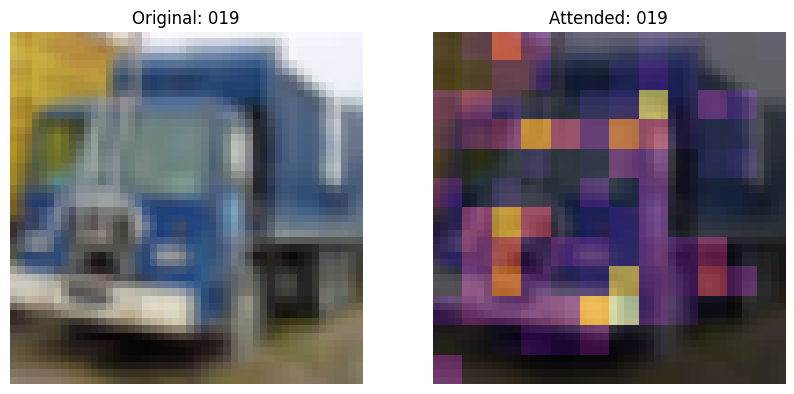

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8682 - top-5-accuracy: 0.9962 - loss: -0.2072 - val_loss: -0.2456
Epoch 21/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 126ms/step - accuracy: 0.8772 - top-5-accuracy: 0.9964 - loss: -0.2180 - val_loss: -0.2114
Epoch 22/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8857 - top-5-accuracy: 0.9964 - loss: -0.2220 - val_loss: -0.2313
Epoch 23/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8887 - top-5-accuracy: 0.9975 - loss: -0.2531 - val_loss: -0.2483
Epoch 24/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9000 - top-5-accuracy: 0.9976 - loss: -0.2657 - val_loss: -0.2206
Epoch 25/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9047 - top-5-accuracy: 0.9983 - loss: -0.2650

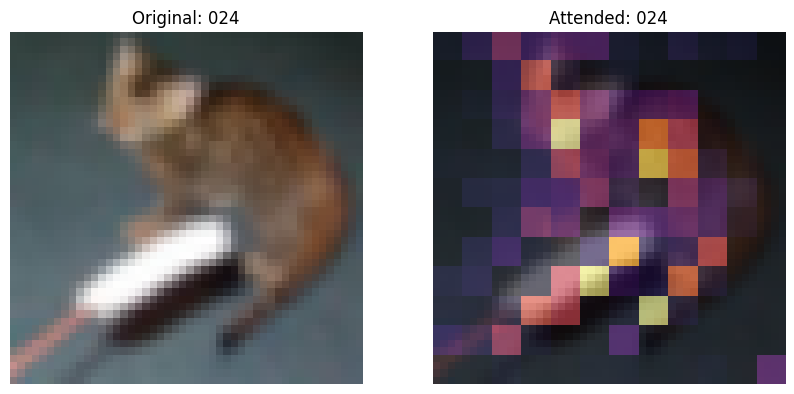

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9044 - top-5-accuracy: 0.9983 - loss: -0.2650 - val_loss: -0.3055
Epoch 26/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.9109 - top-5-accuracy: 0.9984 - loss: -0.2667 - val_loss: -0.2370
Epoch 27/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.9195 - top-5-accuracy: 0.9984 - loss: -0.2729 - val_loss: -0.2905
Epoch 28/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9225 - top-5-accuracy: 0.9988 - loss: -0.2827 - val_loss: -0.3217
Epoch 29/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.9284 - top-5-accuracy: 0.9988 - loss: -0.2835 - val_loss: -0.3053
Epoch 30/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9366 - top-5-accuracy: 0.9994 - loss: -0.3089

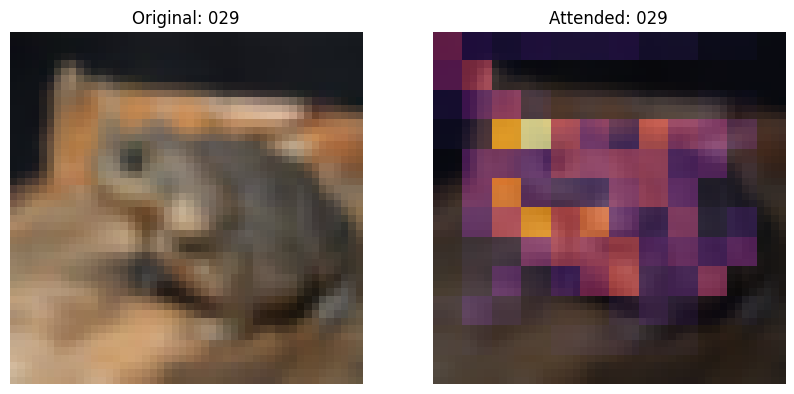

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9363 - top-5-accuracy: 0.9993 - loss: -0.3089 - val_loss: -0.3489
Epoch 31/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.9448 - top-5-accuracy: 0.9996 - loss: -0.3060 - val_loss: -0.2749
Epoch 32/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.9472 - top-5-accuracy: 0.9996 - loss: -0.3209 - val_loss: -0.3647
Epoch 33/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9537 - top-5-accuracy: 0.9997 - loss: -0.3220 - val_loss: -0.3642
Epoch 34/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.9569 - top-5-accuracy: 0.9998 - loss: -0.3593 - val_loss: -0.3638
Epoch 35/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9621 - top-5-accuracy: 0.9999 - loss: -0.3626

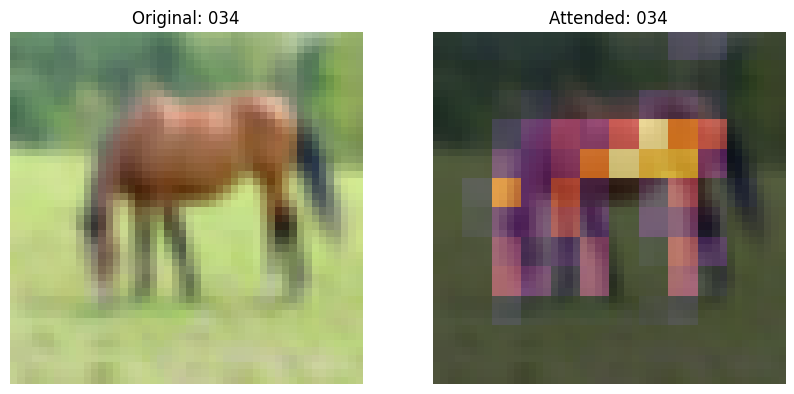

313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.9617 - top-5-accuracy: 0.9999 - loss: -0.3626 - val_loss: -0.3873
Epoch 36/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.9681 - top-5-accuracy: 0.9998 - loss: -0.3609 - val_loss: -0.3594
Epoch 37/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9719 - top-5-accuracy: 0.9999 - loss: -0.3594 - val_loss: -0.3613
Epoch 38/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - accuracy: 0.9722 - top-5-accuracy: 1.0000 - loss: -0.3633 - val_loss: -0.3480
Epoch 39/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - accuracy: 0.9787 - top-5-accuracy: 1.0000 - loss: -0.3562 - val_loss: -0.3764
Epoch 40/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9817 - top-5-accuracy: 0.9999 - loss: -0.3579

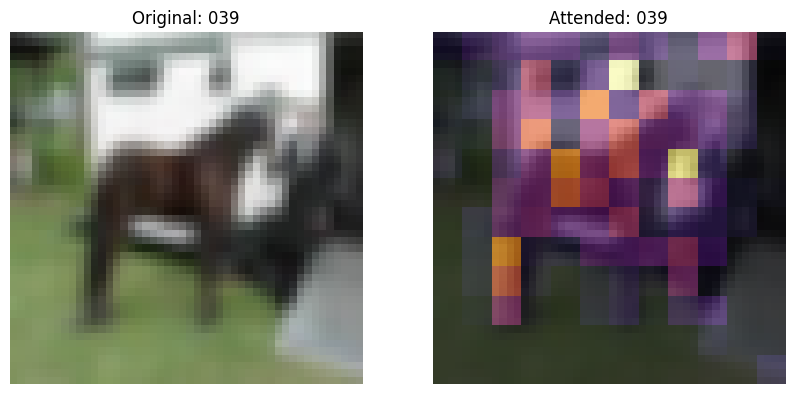

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - accuracy: 0.9813 - top-5-accuracy: 0.9999 - loss: -0.3579 - val_loss: -0.3811
Epoch 41/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.9835 - top-5-accuracy: 1.0000 - loss: -0.3644 - val_loss: -0.3382
Epoch 42/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9864 - top-5-accuracy: 1.0000 - loss: -0.3656 - val_loss: -0.2933
Epoch 43/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9862 - top-5-accuracy: 1.0000 - loss: -0.3358 - val_loss: -0.3699
Epoch 44/50
306/313 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9909 - top-5-accuracy: 1.0000 - loss: -0.3564

In [ ]:
train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)

patch_conv_net = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    train_augmentation_model=train_augmentation_model,
    preprocessing_model=preprocessing_model,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]
# Get the optimizer.
optimizer = keras.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY
)
# Compile and pretrain the model.
patch_conv_net.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = patch_conv_net.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

# Evaluate the model with the test dataset.
loss, acc_top1, acc_top5 = patch_conv_net.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1*100:0.2f}%")
print(f"Top 5 test accuracy: {acc_top5*100:0.2f}%")

## Inference

Here, we use the trained model to plot the attention map.

In [ ]:

def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    image = ops.image.resize(image, (32, 32))
    image = image[np.newaxis, ...]
    test_augmented_images = patch_conv_net.preprocessing_model(image)
    # Pass through the stem.
    test_x = patch_conv_net.stem(test_augmented_images)
    # Pass through the trunk.
    test_x = patch_conv_net.trunk(test_x)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_conv_net.attention_pooling(test_x)
    test_viz_weights = test_viz_weights[np.newaxis, ...]
    # Reshape the vizualization weights.
    num_patches = ops.shape(test_viz_weights)[-1]
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    selected_image = test_augmented_images[0]
    selected_weight = test_viz_weights[0]
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
image_name = keras.utils.get_file(fname="image.jpg", origin=url)
image = keras.utils.load_img(image_name)
image = keras.utils.img_to_array(image)
plot_attention(image)

## Conclusions

The attention map corresponding to the trainable `CLASS`
token and the patches of the image helps explain the classificaiton
decision. One should also note that the attention maps gradually get
better. In the initial training regime, the attention is scattered all
around while at a later stage, it focuses more on the objects of the
image.

The non-pyramidal convnet achieves an accuracy of ~84-85% top-1 test
accuracy.

I would like to thank [JarvisLabs.ai](https://jarvislabs.ai/) for
providing GPU credits for this project.